In [6]:
import os
import pandas as pd
import csv
import numpy as np
import time

from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

log_path = "/home/aayush/accelerometer/accprocess/results/confusion_matrix_output/logs"
predicted_data_path = "/home/aayush/accelerometer/accprocess/results"
# predicted_data_path = "/home/aayush/accelerometer/accprocess/test"
annotated_data_path = "/home/yacine/accel/capture24/participants/"
# annotated_data_path = "/home/aayush/accelerometer/accprocess/test"

labels_dict_location = "/home/aayush/accelerometer/accprocess/anno-label.csv"
confusion_matrix_location = "/home/aayush/accelerometer/accprocess/results/confusion_matrix_output"

In [7]:
class logger:
    def __init__(self) -> None:
        timestamp = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
        log = f"{log_path}/Process_data_{timestamp}.log"
        with open(log, "w") as log_file_save:
            log_file_save.write("################################################\n")
            log_file_save.write("|Timestamp| + \t + |Func| + \t + |Message|\n")
        self.log_file = log
    
    def log(self, func, message) -> None:
        with open(self.log_file, "a") as log_file_save:
            timestamp = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
            log_message = timestamp + "\t" + func + "\t" + message
            log_file_save.write(log_message + "\n")

        # timestamp = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
        # log_message = timestamp + "\t" + func + "\t" + message
        # print(log_message)

logging = logger()

In [8]:
def get_files(data_path, predicted_files=False, annotated_files=False) -> None:
    total_csv_zipped = []
    for path, dirnames, filenames in os.walk(data_path):
        logging.log("get_files", f"Looking for data files in {path}.")
        for file in filenames:
            if file.endswith(".csv.gz") and predicted_files:
                # paths contains the base directory for that file.
                # dirnames contains other directories within this folder.
                # filenames contains the list of filenames within path.
                total_csv_zipped.append(os.path.join(path, file))
                logging.log("get_files", f"Found FILE:{file} in PATH:{path}.")
                
            if file.endswith(".csv") and annotated_files and file[0]!='c': #ignore the capture24 file
                # paths contains the base directory for that file.
                # dirnames contains other directories within this folder.
                # filenames contains the list of filenames within path.
                total_csv_zipped.append(os.path.join(path, file))
                logging.log("get_files", f"Found FILE:{file} in PATH:{path}.")
    logging.log("get_files", "#################################################################################")
    logging.log("get_files", f"######### Total files in the data path: {len(total_csv_zipped)} #########")
    logging.log("get_files", "#################################################################################")
    return sorted(total_csv_zipped)

In [9]:
def create_labels_dict():
    logging.log("create_labels_dict", "Created labels dict for mapping.")
    labels_dict = {}
    with open(labels_dict_location, "r") as annotation_dict:
        reader = csv.DictReader(annotation_dict)
        for row in reader:
            if labels_dict.get(row['annotation']) is None:
                labels_dict[row['annotation']] = [row['label:Walmsley2020']]
            else:
                labels_dict[row['annotation']].append(row['label:Walmsley2020'])
    return labels_dict


def parse_datetime(dt_string):
    clean_datetime_str = dt_string.split('[')[0].strip()
    dt_object = pd.to_datetime(clean_datetime_str)
    return dt_object


def parse_datetime_df_time(dt_string):
    clean_datetime_str = dt_string.split('[')[0].strip()
    clean_datetime_str = clean_datetime_str.split('+')[0].strip()
    dt_object = pd.to_datetime(clean_datetime_str)
    return dt_object

In [10]:
def create_confusion_matrix(actual_labels_cleaned, df_cleaned_filtered):
    assert len(actual_labels_cleaned) == len(df_cleaned_filtered), "DataFrames must be of the same length"

    true_labels = actual_labels_cleaned['annotation']
    predicted_labels = df_cleaned_filtered['activity_predicted']

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=['light', 'moderate-vigorous', 'sedentary', 'sleep'])
    
    logging.log("create_confusion_matrix", "Created confusion matrix.")
    return cm


def display_confusion_matrix(cm, normalize=True):
    logging.log("display_confusion_matrix", "Display confusion matrix.")
    import matplotlib.pyplot as plt
    
    if normalize:
    # Normalize by true values
        cm = cm.astype(float)
        row_sums = cm.sum(axis=1)

        # Avoid division by zero; replace zeros with ones (or a very small number) in the denominator
        row_sums[row_sums == 0] = 1

        # Normalize each row
        cm = cm / row_sums[:, np.newaxis]

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['light', 'mod-vigorous', 'sedentary', 'sleep'])
    disp.plot(cmap='Blues')
    plt.savefig(os.path.join(confusion_matrix_location, datetime.now().strftime("%m-%d-%Y-%H-%M-%S") + ".png"))


In [11]:
predicted_data_files = get_files(data_path=predicted_data_path, predicted_files=True)
annotated_data_files = get_files(data_path=annotated_data_path, annotated_files=True)
assert len(predicted_data_files) == len(annotated_data_files), "Number of predicted and annotated data files should be the same."

labels_dict = create_labels_dict()

labels = ["light", "moderate-vigorous", "sedentary", "sleep"]
combined_cm = np.zeros((len(labels), len(labels)), dtype=float)

In [12]:
def decode_activities(data_file):
    logging.log("decode_activities", f"Decode the activities from file: {data_file}.")
    df = pd.read_csv(data_file)
    
    # retrieve only the activities headers
    activities = df[df.columns.values.tolist()[2:6]]
    
    # whichever activity is depicted by 1, use it as the predicted activity
    out = activities[activities==1].idxmax(axis=1)
    df["activity_predicted"] = out
    
    logging.log("decode_activities", f"Dropped 'nan' activity_predicted from file: {data_file}.")
    df_cleaned = df.dropna(subset=["activity_predicted"])
    return df_cleaned, df
    
    
def process_annotated_data(annotated_data_file):
    logging.log("process_annotated_data", f"Process annotated data file: {annotated_data_file}.")
    
    annotated_data = pd.read_csv(annotated_data_file)
    # Take the timestamp after every thirty seconds
    actual_labels = annotated_data[["annotation", "time"]][0::3000]
    
    # Convert to datetime object
    actual_time = actual_labels["time"].apply(parse_datetime)
    actual_labels["time"] = actual_time

    actual_labels['annotation'].fillna(method='ffill', limit=30, inplace=True) #~15minutes
    
    return actual_labels
    


def filtering_data(df_cleaned, actual_labels, labels_dict):
    
    # Convert to datetime object
    df_cleaned_time = df_cleaned['time'].apply(parse_datetime_df_time)
    df_cleaned['time_cleaned'] = df_cleaned_time
    
    # drop all 'nan' rows from actual labels
    before_dropped_actual_labels = len(actual_labels)
    actual_labels = actual_labels.dropna(subset=['annotation'])
    after_dropped_actual_labels = len(actual_labels)
    count_dropped_actual_labels_na = before_dropped_actual_labels - after_dropped_actual_labels

    before_timestamp_actual_labels = len(actual_labels)
    # Filter out all those timestamps which do not exist in df_cleaned_time
    actual_labels = actual_labels[actual_labels["time"].isin(df_cleaned_time)]
    after_timestamp_actual_labels = len(actual_labels)
    count_timestamp_actual_labels = before_timestamp_actual_labels - after_timestamp_actual_labels

    # Filter out all those timestamps which do not exist in actual_labels
    before_timestamp_predicted = len(df_cleaned)
    df_cleaned_filtered = df_cleaned[df_cleaned['time_cleaned'].isin(actual_labels["time"])]
    after_timestamp_predicted = len(df_cleaned_filtered)
    count_timestamp_predicted = before_timestamp_predicted - after_timestamp_predicted

    
    # Remove all duplicated timestamps from df_cleaned_filtered
    before_predicted_dedup = len(df_cleaned_filtered)
    df_cleaned_filtered_dedup = df_cleaned_filtered[~df_cleaned_filtered['time_cleaned'].duplicated(keep='first')]
    after_predicted_dedup = len(df_cleaned_filtered_dedup)
    count_dropped_predicted_dedup = after_predicted_dedup - before_predicted_dedup
    
    # replace the annotated labels with the same format of strings as predicted labels using mapping from labels_dict
    flat_dict = {k: v[0] for k, v in labels_dict.items()}
    
    actual_labels['annotation'].replace(flat_dict, inplace=True)
    
    return actual_labels, df_cleaned_filtered_dedup, count_dropped_actual_labels_na, count_dropped_predicted_dedup,  count_timestamp_actual_labels, count_timestamp_predicted

In [13]:
df_cleaned_all = []
df_original_all = []

actual_labels_all = []
actual_labels_cleaned_all = []


predicted_items_na_total = 0
count_dropped_actual_labels_na_total = 0
count_dropped_predicted_dedup_total = 0
count_timestamp_actual_labels_total = 0
count_timestamp_predicted_total = 0

for predicted_file, annotated_file in zip(predicted_data_files, annotated_data_files):
    logging.log("main", f"Processing predicted_file: {predicted_file} and annotated_file:{annotated_file}")

    # In this step we drop the activities which are NaN from the predicted data file
    df_cleaned, df_original = decode_activities(predicted_file)

    predicted_items_na_total += len(df_original) - len(df_cleaned)

    # We process the strings to timestamps for annotated file
    actual_labels = process_annotated_data(annotated_file)

    # In this step:
    # We convert the strings to timestamps for cleaned predicted data file
    # drop all 'nan' rows from actual labels
    # Filter out all those timestamps which do not exist in df_cleaned_time
    # Filter out all those timestamps which do not exist in actual_labels
    # Remove all duplicated timestamps from df_cleaned_filtered
    # replace the annotated labels with the same format of strings as predicted labels using mapping from labels_dict
    actual_labels_cleaned, df_cleaned_filtered, count_dropped_actual_labels_na, count_dropped_predicted_dedup,  count_timestamp_actual_labels, count_timestamp_predicted = filtering_data(df_cleaned, actual_labels, labels_dict)

    logging.log("main", f"Number of dropped items from predicted df due to NA values: {len(df_original) - len(df_cleaned)}")
    logging.log("main", f"Number of dropped items from actual_label df due to NA values: {count_dropped_actual_labels_na}")
    logging.log("main", f"Number of dropped items from predicted df due to duplicate timestamps: {count_dropped_predicted_dedup}")
    logging.log("main", f"Number of dropped items from actual_label df due to timestamp mismatch with predicted df: {count_timestamp_actual_labels}")
    logging.log("main", f"Number of dropped items from predicted df due to timestamp mismatch with actual_label df: {count_timestamp_predicted}")
    

    count_dropped_actual_labels_na_total += count_dropped_actual_labels_na
    count_dropped_predicted_dedup_total += count_dropped_predicted_dedup
    count_timestamp_actual_labels_total += count_timestamp_actual_labels
    count_timestamp_predicted_total += count_timestamp_predicted
    
    
    cm = create_confusion_matrix(actual_labels_cleaned, df_cleaned_filtered)
    combined_cm += cm

    df_cleaned_all.append(df_cleaned_filtered)
    df_original_all.append(df_original)
    
    actual_labels_all.append(actual_labels)
    actual_labels_cleaned_all.append(actual_labels_cleaned)
    
print("##############DONE#############")

/tmp/ipykernel_3027115/3086656316.py:23: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_3027115/1098116365.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time
/tmp/ipykernel_3027115/3086656316.py:23: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_3027115/3086656316.py:23: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)
/tmp/ipykernel_3027115/3086656316

##############DONE#############


/tmp/ipykernel_3027115/1098116365.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['time_cleaned'] = df_cleaned_time


In [14]:
df_cleaned_all_pd = pd.concat(df_cleaned_all, ignore_index=True, axis=0)
df_original_all_pd = pd.concat(df_original_all, ignore_index=True, axis=0)

actual_labels_all_pd = pd.concat(actual_labels_all, ignore_index=True, axis=0)
actual_labels_cleaned_all_pd = pd.concat(actual_labels_cleaned_all, ignore_index=True, axis=0)

In [15]:
print(f"Number of dropped items from predicted df due to NA values: {predicted_items_na_total}")
print(f"Number of dropped items from actual_label df due to NA values: {count_dropped_actual_labels_na_total}")
print(f"Number of dropped items from predicted df due to duplicate timestamps: {count_dropped_predicted_dedup_total}")
print(f"Number of dropped items from actual_label df due to timestamp mismatch with predicted df: {count_timestamp_actual_labels_total}")
print(f"Number of dropped items from predicted df due to timestamp mismatch with actual_label df: {count_timestamp_predicted_total}")

Number of dropped items from predicted df due to NA values: 5176
Number of dropped items from actual_label df due to NA values: 113817
Number of dropped items from predicted df due to duplicate timestamps: -120
Number of dropped items from actual_label df due to timestamp mismatch with predicted df: 14874
Number of dropped items from predicted df due to timestamp mismatch with actual_label df: 124894


In [16]:
print(df_cleaned_all_pd)
print(df_original_all_pd)

print(actual_labels_all_pd)
print(actual_labels_cleaned_all_pd)

                                                   time    acc  light  \
0       2016-11-13 02:18:00.000000+0000 [Europe/London]  0.767    0.0   
1       2016-11-13 02:18:30.000000+0000 [Europe/London]  0.819    0.0   
2       2016-11-13 02:19:00.000000+0000 [Europe/London]  1.226    0.0   
3       2016-11-13 02:19:30.000000+0000 [Europe/London]  1.292    0.0   
4       2016-11-13 02:20:00.000000+0000 [Europe/London]  1.213    0.0   
...                                                 ...    ...    ...   
337458  2016-06-12 06:17:00.000000+0100 [Europe/London]  4.435    0.0   
337459  2016-06-12 06:17:30.000000+0100 [Europe/London]  4.513    0.0   
337460  2016-06-12 06:18:00.000000+0100 [Europe/London]  4.288    0.0   
337461  2016-06-12 06:18:30.000000+0100 [Europe/London]  1.313    0.0   
337462  2016-06-12 06:19:00.000000+0100 [Europe/London]  0.968    0.0   

        moderate-vigorous  sedentary  sleep  CpSB  CpLPA  CpMPA  CpVPA  \
0                     0.0        0.0    1.0   0.0

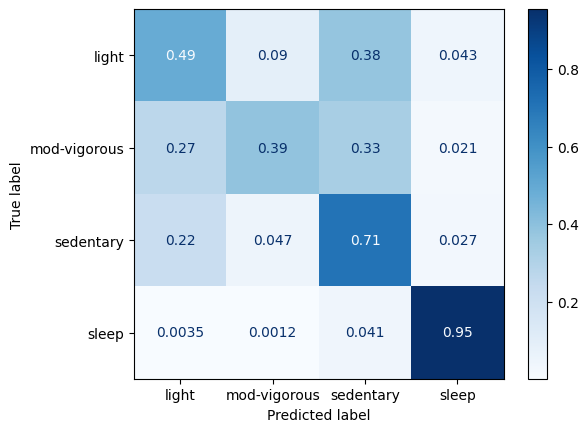

In [17]:
display_confusion_matrix(combined_cm, normalize=True)

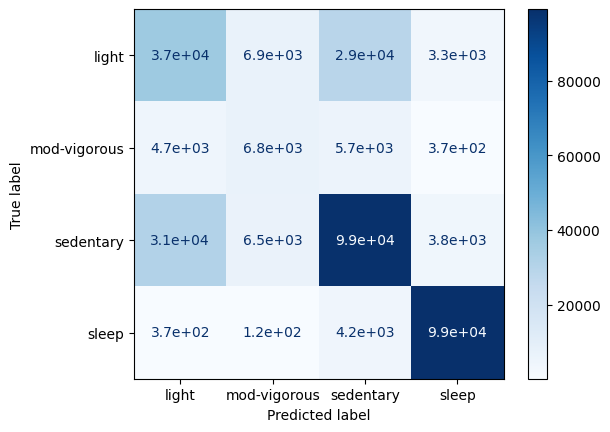

In [18]:
display_confusion_matrix(combined_cm, normalize=False)